# Environmental Risk Discourse Evolution in SEC 10-K Filings:
# Part 2: Deep Learning Model

## Import packages

In [ ]:
# import os
# !pip install numpy==1.26.4 --quiet
# os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 118.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
!pip install torchsummary
!pip install torch-geometric

# Data handling and analysis
import pandas as pd
import numpy as np
import re
import random
import ast

# stuff
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import string
import shutil

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch and related tools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Torch Geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Torch summary
from torchsummary import summary

# Torchvision
import torchvision
from torchvision import datasets, transforms

# Transformers & Huggingface datasets
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForCausalLM, TrainingArguments, Trainer,
    BitsAndBytesConfig, DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)

from datasets import Dataset, DatasetDict

# PEFT (parameter efficient fine-tuning, e.g. LoRA)
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import peft

# TensorFlow & tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    precision_recall_curve, roc_curve, auc, f1_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Statistical tools and progress bars
import scipy.stats as stats
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto  # alias for tqdm in some workflows

# Graph/networkx
import networkx as nx

# Google Colab + File I/O (optional, comment out if not on Colab)
try:
    from google.colab import drive
except ImportError:
    pass
import zipfile
import tarfile
import os

# System/process tools
import subprocess
import sys
import time
import warnings

# Set environment variables for stability (transformers/peft)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging
os.environ["TRANSFORMERS_VERBOSITY"] = "error"  # Reduce transformer warnings

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set up device for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Read in preprocessed Data

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/preprocessed_s&p_csv.zip"

dfs = {}

with zipfile.ZipFile(zip_path) as zf:
    csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
    for name in csv_names:
        # get short code from filename
        base = name.rsplit("/", 1)[-1]               # drop folders
        code = re.sub(r"\.csv$", "", base, flags=re.I)
        # Read CSV directly from zip (handles utf-8 by default)
        with zf.open(name) as f:
            dfs[code] = pd.read_csv(f)
            # If you really want variables A, B, C ... (not recommended):
            # globals()[code] = dfs[code]

# Quick check
# list(dfs.keys()), {k: dfs[k].shape for k in dfs}

In [6]:
len(dfs.keys())

215

In [7]:
data = pd.concat(
    [df.assign(source=code) for code, df in dfs.items()],
    axis=0,
    ignore_index=True
)
data.shape

(3896, 10)

In [ ]:
display(data)

,cik,FiscalYearEnd,URL,sentences,sentence_count,word_count,climate_sentences,climate_words,climate_ratio,source
0,1090872,2024-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks General economi...,304,9067,"['Also, in such an environment, pricing pressu...","['droughts', 'earthquake', 'environment', 'ext...",0.026316,A
1,1090872,2023-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks General economi...,295,8664,"['Also, in such an environment, pricing pressu...","['droughts', 'earthquake', 'environment', 'ext...",0.020339,A
2,1090872,2022-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks The COVID-19 pa...,291,8550,"['As COVID-19 conditions have improved, the du...","['droughts', 'earthquake', 'environment', 'ext...",0.024055,A
3,1090872,2021-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks The COVID-19 pa...,300,8794,"['To the extent COVID-19 conditions improve, t...","['earthquake', 'environment', 'extreme weather...",0.020000,A
4,1090872,2020-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,"['Risks, Uncertainties and Other Factors Speci...",298,8636,"['To the extent COVID-19 conditions improve, t...","['earthquake', 'environment', 'extreme weather...",0.020134,A
...,...,...,...,...,...,...,...,...,...,...
3891,1136869,2009-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,117,3512,['We operate in ahighly competitive environmen...,['environment'],0.008547,ZBH
3892,1136869,2008-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,135,4049,['We operate in ahighly competitive environmen...,['environment'],0.007407,ZBH
3893,1136869,2007-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,179,5110,['We operate in ahighly competitive environmen...,['environment'],0.005587,ZBH
3894,1136869,2006-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,161,4619,['We operate in ahighly competitive environmen...,['environment'],0.006211,ZBH


In [14]:
type(data["sentences"][0])

list

In [15]:
# Convert strings to actual lists
for col in ["sentences", "climate_sentences"]:
    data[col] = data[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# PART 2: Environmental Risk Detection and Sentiment

## Preprocessing

In [ ]:
# Problem: After exploding it is not ensured that the ordering stays the same. Therefore add a column which encodes the correct order for the sentences.

In [20]:
df_env_risk = (
    data
    .assign(
        sentence_order=lambda d: d["sentences"].apply(
            lambda sents: list(range(len(sents))) if isinstance(sents, list) else []
        )
    )
    .explode(["sentences", "sentence_order"])  # explode both columns to get also the ordering
    .reset_index(drop=True)
    [["cik", "FiscalYearEnd", "sentences", "climate_sentences", "sentence_order"]]
)

In [21]:
df_env_risk

,cik,FiscalYearEnd,sentences,climate_sentences,sentence_order
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,"[Also, in such an environment, pricing pressur...",0
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,"[Also, in such an environment, pricing pressur...",1
2,1090872,2024-10-31 00:00:00,"Slower global economic growth, increasing inte...","[Also, in such an environment, pricing pressur...",2
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,"[Also, in such an environment, pricing pressur...",3
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,"[Also, in such an environment, pricing pressur...",4
...,...,...,...,...,...
968142,1136869,2005-12-31 00:00:00,Reconstructive implants produce the highest op...,[We operate in ahighly competitive environment.],149
968143,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,[We operate in ahighly competitive environment.],150
968144,1136869,2005-12-31 00:00:00,Sales in our Americas region accounted for app...,[We operate in ahighly competitive environment.],151
968145,1136869,2005-12-31 00:00:00,Sales in the Americas region produce the highe...,[We operate in ahighly competitive environment.],152


In [22]:
# Normalize whitespace in each sentence
df_env_risk["sentences"] = df_env_risk["sentences"].apply(
    lambda s: re.sub(r"\s+", " ", s.strip()) if isinstance(s, str) else s
)

In [23]:
# Drop exact duplicates across dataset
df_env_risk = df_env_risk.drop_duplicates(subset=["sentences"]).reset_index(drop=True)

# Filter by word count
df_env_risk["n_words"] = df_env_risk["sentences"].str.split().str.len()
df_env_risk = df_env_risk[
    (df_env_risk["n_words"] >= 4) & (df_env_risk["n_words"] <= 80)
].copy()

# Create baseline potential label
df_env_risk["dict_label"] = df_env_risk.apply(
    lambda row: int(row["sentences"] in row["climate_sentences"]), axis=1
)

df_env_risk = df_env_risk.drop(columns=["n_words", "climate_sentences"]).rename(columns={'sentences': 'text'})

df_env_risk[df_env_risk["dict_label"] == 1]

,cik,FiscalYearEnd,text,sentence_order,dict_label
11,1090872,2024-10-31 00:00:00,"Also, in such an environment, pricing pressure...",11,1
132,1090872,2024-10-31 00:00:00,"In addition, the global regulatory environment...",132,1
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1
173,1090872,2024-10-31 00:00:00,Our current and historical manufacturing and r...,173,1
193,1090872,2024-10-31 00:00:00,"Moreover, AI is subject to adynamic and rapidl...",193,1
...,...,...,...,...,...
396127,1136869,2024-12-31 00:00:00,"We operate in arapidly changing competitive, e...",0,1
396265,1136869,2024-12-31 00:00:00,As discussed further in Note 11 to our consoli...,148,1
396298,1136869,2024-12-31 00:00:00,Our global regulatory environment is increasin...,181,1
396416,1136869,2023-12-31 00:00:00,As discussed further in Note 11 to our consoli...,142,1


## Baseline FinBERT-ESG

We now set up the FinBERT-ESG to label E related sentences as a naive baseline.

We label the whole dataset to get a baseline label for comparison with the potential label (from the dictionary method) and to create a stratified sample for manual labeling to fine tune the model later.

In [88]:
# Load FinBERT-ESG baseline (4-class model)
model_E_baseline_name = "yiyanghkust/finbert-esg"
tokenizer = AutoTokenizer.from_pretrained(model_E_baseline_name)
model_E_baseline = AutoModelForSequenceClassification.from_pretrained(model_E_baseline_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_E_baseline.to(device)

id2label_E_baseline = model_E_baseline.config.id2label

print("Baseline id2label mapping:", id2label_E_baseline)

Baseline id2label mapping: {0: 'None', 1: 'Environmental', 2: 'Social', 3: 'Governance'}


In [91]:
def predict_e_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting ESG labels"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        # Map: 1 = Environmental, else 0
        binary = [1 if p == 1 else 0 for p in batch_preds]
        preds.extend(binary)
    return preds

df_env_risk["baseline_label"] = predict_e_texts(df_env_risk["text"].tolist(), model_E_baseline, batch_size=32)

Predicting ESG labels: 100%|██████████| 759/759 [02:01<00:00,  6.23it/s]


In [ ]:
display(df_env_risk[df_env_risk['baseline_label'] == 1])

,cik,FiscalYearEnd,text,dict_label,baseline_label
132,1090872,2024-10-31 00:00:00,"In addition, the global regulatory environment...",1,1
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,1,1
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",0,1
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,0,1
159,1090872,2024-10-31 00:00:00,"In addition, we face increasing scrutiny from ...",0,1
...,...,...,...,...,...
395991,1041061,2009-12-26 00:00:00,Increased regulation of and opposition to gene...,0,1
396063,1041061,2008-01-28 00:00:00,Increased regulation of and opposition to gene...,0,1
396102,1041061,2006-12-31 00:00:00,"Finally, like other companies in the restauran...",0,1
396111,1041061,2006-12-31 00:00:00,"In addition to food, we purchase electricity, ...",0,1


### Comparing dict_label and baseline_label

Value counts dict_label:
 dict_label
0    369150
1     12036
Name: count, dtype: int64 

Value counts baseline_label:
 baseline_label
0    366153
1     15033
Name: count, dtype: int64 

=== Comparison dict_label vs. baseline_label ===

              precision    recall  f1-score   support

not relevant     0.9802    0.9723    0.9762    369150
    relevant     0.3191    0.3986    0.3544     12036

    accuracy                         0.9542    381186
   macro avg     0.6497    0.6854    0.6653    381186
weighted avg     0.9594    0.9542    0.9566    381186

Confusion Matrix:
 [[358914  10236]
 [  7239   4797]]


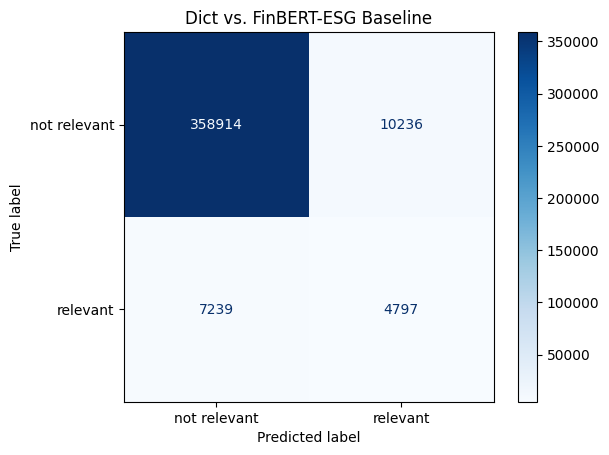

In [ ]:
# Basic comparison counts
print("Value counts dict_label:\n", df_env_risk["dict_label"].value_counts(), "\n")
print("Value counts baseline_label:\n", df_env_risk["baseline_label"].value_counts(), "\n")

# Classification metrics (treat dict_label as reference/ground truth although its not the case)
y_true = df_env_risk["dict_label"].astype(int)
y_pred = df_env_risk["baseline_label"].astype(int)

print("=== Comparison dict_label vs. baseline_label ===\n")
print(classification_report(y_true, y_pred, target_names=["not relevant", "relevant"], digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not relevant","relevant"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Dict vs. FinBERT-ESG Baseline")
plt.show()

## Create Data with manual annotations

Do stratified sampling based on the basline_label and then manually label the data.

In [ ]:
df_env_risk

,cik,FiscalYearEnd,text,dict_label,baseline_label,baseline_sentiment_id,sentiment,doc_id
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,0,0,2,Negative,1090872_2024-10-31
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,0,0,2,Negative,1090872_2024-10-31
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,0,0,2,Negative,1090872_2024-10-31
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,0,0,2,Negative,1090872_2024-10-31
5,1090872,2024-10-31 00:00:00,Our quarterly sales and operating results are ...,0,0,0,Neutral,1090872_2024-10-31
...,...,...,...,...,...,...,...,...
397600,1136869,2005-12-31 00:00:00,"If, as aresult of this investigation, we are f...",0,0,2,Negative,1136869_2005-12-31
397602,1136869,2005-12-31 00:00:00,If some of the business practices of our indep...,0,0,2,Negative,1136869_2005-12-31
397603,1136869,2005-12-31 00:00:00,"In 2005, we derived approximately $1,344 milli...",0,0,0,Neutral,1136869_2005-12-31
397604,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,0,0,0,Neutral,1136869_2005-12-31


In [ ]:
n_pos, n_neg = 4000, 4000   # target samples
cap_per_doc = 50            # max sentences per document
rng = 123                   # reproducibility seed

df_env_risk["doc_id"] = (
    df_env_risk["cik"].astype(str) + "_" + pd.to_datetime(df_env_risk["FiscalYearEnd"]).dt.date.astype(str)
)

# stratified sample with cap per doc_id
def stratified_doc_sample(pool, target_n, cap_per_doc=50, random_state=123):
    if len(pool) <= target_n:
        return pool

    # sample up to cap_per_doc per doc_id
    parts = []
    for _, g in pool.groupby("doc_id"):
        k = min(cap_per_doc, len(g))
        parts.append(g.sample(n=k, random_state=random_state))
    sampled = pd.concat(parts, axis=0)

    # adjust to exact target size
    if len(sampled) > target_n:
        sampled = sampled.sample(n=target_n, random_state=random_state)
    elif len(sampled) < target_n:
        remainder = pool.drop(sampled.index)
        need = min(target_n - len(sampled), len(remainder))
        if need > 0:
            sampled = pd.concat([sampled, remainder.sample(n=need, random_state=random_state)], axis=0)

    return sampled

# Split into pos/neg pools
pos_pool = df_env_risk[df_env_risk["baseline_label"] == 1]
neg_pool = df_env_risk[df_env_risk["baseline_label"] == 0]

# Sample with cap per doc
sample_pos = stratified_doc_sample(pos_pool, n_pos, cap_per_doc=cap_per_doc, random_state=rng)
sample_neg = stratified_doc_sample(neg_pool, n_neg, cap_per_doc=cap_per_doc, random_state=rng)

# Combine and shuffle
labeling_set_env_risk = (
    pd.concat([sample_pos, sample_neg], axis=0)
      .sample(frac=1, random_state=rng)
      .reset_index(drop=True)
)

# Add column for manual label (2 = not labeled yet)
labeling_set_env_risk["label"] = 2

print("Class counts in sample:")
print(labeling_set_env_risk["baseline_label"].value_counts())
print("Total docs covered:", labeling_set_env_risk["doc_id"].nunique())

# Rearange columns
labeling_set_env_risk = labeling_set_env_risk[['cik', 'FiscalYearEnd', 'text', 'label',
                                               'baseline_label', 'dict_label', 'sentiment']]

# Export to Excel
labeling_set_env_risk.to_excel("labeling_set_env_risk.xlsx", index=False)

print("✅ Exported labeling set to labeling_set_env_risk.xlsx")

Class counts in sample:
baseline_label
0    4000
1    4000
Name: count, dtype: int64
Total docs covered: 2780
✅ Exported labeling set to labeling_set_env_risk.xlsx


In [ ]:
from google.colab import files
# Download
files.download("labeling_set_env_risk.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
labeling_set_env_risk

,cik,FiscalYearEnd,text,label,baseline_label,dict_label,sentiment
0,796343,2022-12-02 00:00:00,We may incur losses associated with currency f...,2,0,0,Negative
1,1002910,2007-12-31 00:00:00,We believe that any potential resolution would...,2,1,1,Neutral
2,1133421,2016-12-31 00:00:00,We are and may become aparty to various legal ...,2,1,0,Neutral
3,1048286,2005-12-30 00:00:00,"We develop new hotel, timeshare, fractional ow...",2,0,0,Neutral
4,1341439,2006-05-31 00:00:00,An active acquisition program is an important ...,2,0,0,Neutral
...,...,...,...,...,...,...,...
7995,769397,2008-01-31 00:00:00,"See Note 6, “Commitments and Contingencies” in...",2,0,0,Neutral
7996,1111711,2018-12-31 00:00:00,"In addition, the nature of the information ava...",2,1,0,Negative
7997,92122,2016-12-31 00:00:00,"The remainder of the plant, including the gasi...",2,1,0,Neutral
7998,715957,2014-12-31 00:00:00,"In such an event, Dominion may not be able to ...",2,0,0,Neutral


In [ ]:
labeling_set_env_risk['sentiment'].value_counts()

,count
sentiment,
Neutral,4651
Negative,3075
Positive,274


Label, Label, Label ....

In [24]:
# Load labeled file

labeled_set_env_risk = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/labeling_set_env_risk.xlsx")

In [27]:
labeled_set_env_risk

,cik,FiscalYearEnd,text,label,baseline_label,dict_label,sentiment,mein Sentiment
0,796343,2022-12-02 00:00:00,We may incur losses associated with currency f...,0,0,0,Negative,NaN
1,1002910,2007-12-31 00:00:00,We believe that any potential resolution would...,1,1,1,Neutral,NaN
2,1133421,2016-12-31 00:00:00,We are and may become aparty to various legal ...,1,1,0,Neutral,NaN
3,1048286,2005-12-30 00:00:00,"We develop new hotel, timeshare, fractional ow...",0,0,0,Neutral,NaN
4,1341439,2006-05-31 00:00:00,An active acquisition program is an important ...,0,0,0,Neutral,NaN
...,...,...,...,...,...,...,...,...
7995,769397,2008-01-31 00:00:00,"See Note 6, “Commitments and Contingencies” in...",2,0,0,Neutral,NaN
7996,1111711,2018-12-31 00:00:00,"In addition, the nature of the information ava...",2,1,0,Negative,NaN
7997,92122,2016-12-31 00:00:00,"The remainder of the plant, including the gasi...",2,1,0,Neutral,NaN
7998,715957,2014-12-31 00:00:00,"In such an event, Dominion may not be able to ...",2,0,0,Neutral,NaN


In [26]:
labeled_set_env_risk['label'].value_counts()

,count
label,
2,6816
0,670
1,514


In [28]:
# Build a datset for training FinBERT-ESG

data_FinBERT = labeled_set_env_risk[labeled_set_env_risk['label'] != 2][['text', 'label']]

In [29]:
data_FinBERT

,text,label
0,We may incur losses associated with currency f...,0
1,We believe that any potential resolution would...,1
2,We are and may become aparty to various legal ...,1
3,"We develop new hotel, timeshare, fractional ow...",0
4,An active acquisition program is an important ...,0
...,...,...
6240,"For example, there is an increase in enforceme...",0
6241,The following risk factors could have amateria...,0
6245,We consumed approximately 376 million gallons ...,0
6248,In recent years we have provided greater trans...,1


## Fine-tuned FinBERT-ESG

We now fine tune the FinBERT-ESG to label E related sentences using the manually labeled data.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [32]:
train_A, rest_A = train_test_split(
    data_FinBERT,
    test_size=0.20,
    random_state=42,
    stratify=data_FinBERT['label']
)

val_A, test_A = train_test_split(
    rest_A,
    test_size=0.50,
    random_state=42,
    stratify=rest_A['label']
)

print(f"Train: {len(train_A)}, Val: {len(val_A)}, Test: {len(test_A)}")
print("Train class distribution:\n", train_A['label'].value_counts(normalize=True))
print("Val class distribution:\n", val_A['label'].value_counts(normalize=True))
print("Test class distribution:\n", test_A['label'].value_counts(normalize=True))

# Convert to Hugging Face DatasetDict
train_A_ds = Dataset.from_pandas(train_A)
val_A_ds = Dataset.from_pandas(val_A)
test_A_ds = Dataset.from_pandas(test_A)

dataset_A = DatasetDict({
    "train": train_A_ds,
    "validation": val_A_ds,
    "test": test_A_ds
})

Train: 947, Val: 118, Test: 119
Train class distribution:
 label
0    0.565998
1    0.434002
Name: proportion, dtype: float64
Val class distribution:
 label
0    0.567797
1    0.432203
Name: proportion, dtype: float64
Test class distribution:
 label
0    0.563025
1    0.436975
Name: proportion, dtype: float64


In [65]:
model_name = "yiyanghkust/finbert-esg"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Replace classification head with binary (2-class) head
model_E = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True   # re-initialize head
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_E.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [66]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

dataset_tok = dataset_A.map(tokenize, batched=True)
dataset_tok = dataset_tok.remove_columns(
    [c for c in dataset_tok["train"].column_names if c not in ["input_ids","attention_mask","label"]]
)
dataset_tok.set_format("torch")

Map:   0%|          | 0/947 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

In [70]:
# LoRA Config for sequence classification
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,      # sequence classification
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"]  # BERT layers
)

# Apply PEFT wrapper
model_E_lora = get_peft_model(model_E, lora_config)
model_E_lora.print_trainable_parameters()

trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839


In [72]:
# TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert_esg_lora_finetune",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,           # increase if GPU memory is tight
    warmup_steps=100,
    learning_rate=1e-4,
    fp16=torch.cuda.is_available(),          # use mixed precision if GPU supports
    logging_steps=20,
    logging_dir="./logs",
    eval_strategy="steps",                   # evaluate at end of each epoch
    eval_steps=25,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="recall",          # Take recall as main metric because we want to identifie as many truly E related sentences as possible
    greater_is_better=True,
    report_to=[],                            # disable external loggers
    remove_unused_columns=False,             # needed for PEFT
    dataloader_pin_memory=True,
    max_grad_norm=1.0,
)

In [73]:
from transformers import default_data_collator
from transformers import EarlyStoppingCallback

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Ensure padding is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token or tokenizer.unk_token
model_E_lora.config.pad_token_id = tokenizer.pad_token_id

# Trainer
trainer = Trainer(
    model=model_E_lora,
    args=training_args,
    train_dataset=dataset_tok["train"],
    eval_dataset=dataset_tok["validation"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [74]:
# Train
print("🚀 Starting LoRA fine-tuning...")
training_output = trainer.train()
print("✅ LoRA fine-tuning completed!")
print(f"📊 Final training loss: {training_output.training_loss:.4f}")

# Save
print("💾 Saving fine-tuned model...")
trainer.save_model("./finbert-esg-lora-finetuned")
tokenizer.save_pretrained("./finbert-esg-lora-finetuned")

# Evaluate on test set
print("📈 Final test evaluation:")
test_results = trainer.evaluate(dataset_tok["test"])
print(test_results)

🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.728800,0.658366,0.677966,0.610169,0.705882,0.654545
50,0.596400,0.430052,0.830508,0.731343,0.960784,0.830508
75,0.378000,0.390627,0.838983,0.758065,0.921569,0.831858
100,0.222100,0.431796,0.838983,0.758065,0.921569,0.831858


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4474
💾 Saving fine-tuned model...
📈 Final test evaluation:


{'eval_loss': 0.39610639214515686, 'eval_accuracy': 0.8739495798319328, 'eval_precision': 0.8032786885245902, 'eval_recall': 0.9423076923076923, 'eval_f1': 0.8672566371681416, 'eval_runtime': 0.6142, 'eval_samples_per_second': 193.746, 'eval_steps_per_second': 6.512, 'epoch': 3.3333333333333335}


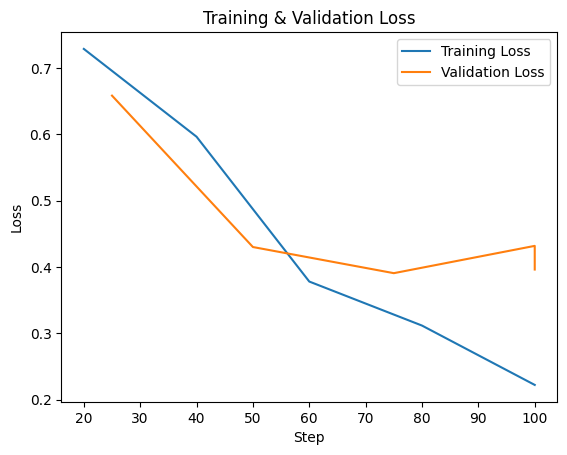

In [75]:
# ✅ Plot learning curves
logs_df = pd.DataFrame(trainer.state.log_history)

plt.plot(logs_df[logs_df['loss'].notna()]["step"], logs_df[logs_df['loss'].notna()]["loss"], label='Training Loss')
plt.plot(logs_df[logs_df['eval_loss'].notna()]["step"], logs_df[logs_df['eval_loss'].notna()]["eval_loss"], label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [80]:
# Load Best Model

# Its already stored in the Trainer :)

model_E_lora_best = trainer.model

model_E_lora_best.to(device)
model_E_lora_best.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30873, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default


=== VALIDATION RESULTS ===
              precision    recall  f1-score   support

not relevant     0.9286    0.7761    0.8455        67
    relevant     0.7581    0.9216    0.8319        51

    accuracy                         0.8390       118
   macro avg     0.8433    0.8488    0.8387       118
weighted avg     0.8549    0.8390    0.8396       118

Confusion Matrix:
 [[52 15]
 [ 4 47]]


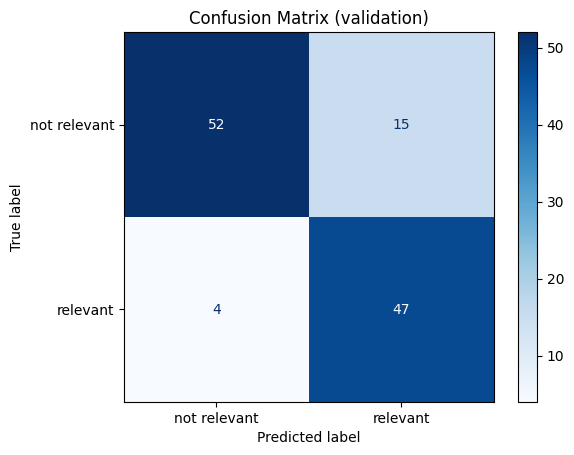


=== TEST RESULTS ===
              precision    recall  f1-score   support

not relevant     0.9483    0.8209    0.8800        67
    relevant     0.8033    0.9423    0.8673        52

    accuracy                         0.8739       119
   macro avg     0.8758    0.8816    0.8736       119
weighted avg     0.8849    0.8739    0.8744       119

Confusion Matrix:
 [[55 12]
 [ 3 49]]


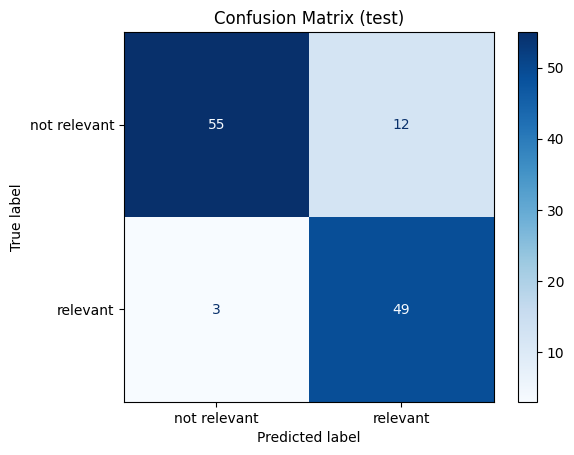

In [76]:
# Evaluate

def evaluate_model(trainer, dataset, split_name="validation", class_names=["not relevant","relevant"]):
    # Run prediction
    preds_output = trainer.predict(dataset)
    y_true = preds_output.label_ids
    y_probs = preds_output.predictions
    y_pred = np.argmax(y_probs, axis=1)

    print(f"\n=== {split_name.upper()} RESULTS ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(f"Confusion Matrix ({split_name})")
    plt.show()

# Run on val and test
evaluate_model(trainer, dataset_tok["validation"], split_name="validation")
evaluate_model(trainer, dataset_tok["test"], split_name="test")

### Classify all sentences

In [81]:
def predict_e_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting ESG labels"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        # Map: 1 = Environmental, else 0 (also true for my new binary mapping)
        binary = [1 if p == 1 else 0 for p in batch_preds]
        preds.extend(binary)
    return preds

df_env_risk["label"] = predict_e_texts(df_env_risk["text"].tolist(), model_E_lora_best, batch_size=32)

Predicting ESG labels: 100%|██████████| 11913/11913 [12:24<00:00, 16.01it/s]


In [84]:
df_env_risk

,cik,FiscalYearEnd,text,sentence_order,dict_label,label
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,0,0,0
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,1,0,0
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,3,0,0
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,4,0,0
5,1090872,2024-10-31 00:00:00,Our quarterly sales and operating results are ...,5,0,0
...,...,...,...,...,...,...
397600,1136869,2005-12-31 00:00:00,"If, as aresult of this investigation, we are f...",36,0,0
397602,1136869,2005-12-31 00:00:00,If some of the business practices of our indep...,78,0,0
397603,1136869,2005-12-31 00:00:00,"In 2005, we derived approximately $1,344 milli...",89,0,0
397604,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,150,0,0


In [83]:
df_env_risk['label'].value_counts()

,count
label,
0,356918
1,24268


## FinBERT-tone

We now set up the FinBERT-tone to get the sentiment of E related sentences.

In [90]:
df_env_risk_tone = df_env_risk[df_env_risk['label'] == 1]

df_env_risk_tone["baseline_label"] = predict_e_texts(df_env_risk_tone["text"].tolist(), model_E_baseline, batch_size=32)

,cik,FiscalYearEnd,text,sentence_order,dict_label,label
132,1090872,2024-10-31 00:00:00,"In addition, the global regulatory environment...",132,1,1
137,1090872,2024-10-31 00:00:00,Some of our products are subject to particular...,137,0,1
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1,1
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",139,0,1
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,140,0,1
...,...,...,...,...,...,...
396068,1041061,2008-01-28 00:00:00,While we take measures to anticipate and react...,29,0,1
396087,1041061,2008-01-28 00:00:00,Requirements of local authorities with respect...,64,0,1
396102,1041061,2006-12-31 00:00:00,"Finally, like other companies in the restauran...",14,0,1
396111,1041061,2006-12-31 00:00:00,"In addition to food, we purchase electricity, ...",31,0,1


In [92]:

df_env_risk_tone

,cik,FiscalYearEnd,text,sentence_order,dict_label,label,baseline_label
132,1090872,2024-10-31 00:00:00,"In addition, the global regulatory environment...",132,1,1,1
137,1090872,2024-10-31 00:00:00,Some of our products are subject to particular...,137,0,1,0
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1,1,1
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",139,0,1,1
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,140,0,1,1
...,...,...,...,...,...,...,...
396068,1041061,2008-01-28 00:00:00,While we take measures to anticipate and react...,29,0,1,0
396087,1041061,2008-01-28 00:00:00,Requirements of local authorities with respect...,64,0,1,0
396102,1041061,2006-12-31 00:00:00,"Finally, like other companies in the restauran...",14,0,1,1
396111,1041061,2006-12-31 00:00:00,"In addition to food, we purchase electricity, ...",31,0,1,1


In [93]:
# Load FinBERT-tone (3-class sentiment model)
model_tone_name = "yiyanghkust/finbert-tone"
tokenizer_tone = AutoTokenizer.from_pretrained(model_tone_name)
model_tone = AutoModelForSequenceClassification.from_pretrained(model_tone_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_tone.to(device)

id2label_tone = model_tone.config.id2label

print("id2label mapping (tone):", id2label_tone)

id2label mapping (tone): {0: 'Neutral', 1: 'Positive', 2: 'Negative'}


In [94]:
# Classify all sentences

def predict_tone_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting Sentiment"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer_tone(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        preds.extend(batch_preds)
    return preds

# Apply to your DataFrame (adds numeric sentiment label)
df_env_risk_tone["sentiment_id"] = predict_tone_texts(
    df_env_risk_tone["text"].tolist(),
    model_tone,
    batch_size=256
)

# Map numeric predictions back to sentiment labels
df_env_risk_tone["sentiment"] = df_env_risk_tone["sentiment_id"].map(id2label_tone)

Predicting Sentiment: 100%|██████████| 95/95 [02:16<00:00,  1.44s/it]


In [96]:
df_env_risk_tone

,cik,FiscalYearEnd,text,sentence_order,dict_label,label,baseline_label,sentiment_id,sentiment
132,1090872,2024-10-31 00:00:00,"In addition, the global regulatory environment...",132,1,1,1,0,Neutral
137,1090872,2024-10-31 00:00:00,Some of our products are subject to particular...,137,0,1,0,2,Negative
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1,1,1,0,Neutral
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",139,0,1,1,0,Neutral
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,140,0,1,1,0,Neutral
...,...,...,...,...,...,...,...,...,...
396068,1041061,2008-01-28 00:00:00,While we take measures to anticipate and react...,29,0,1,0,2,Negative
396087,1041061,2008-01-28 00:00:00,Requirements of local authorities with respect...,64,0,1,0,2,Negative
396102,1041061,2006-12-31 00:00:00,"Finally, like other companies in the restauran...",14,0,1,1,2,Negative
396111,1041061,2006-12-31 00:00:00,"In addition to food, we purchase electricity, ...",31,0,1,1,0,Neutral


In [97]:

display(df_env_risk_tone[(df_env_risk_tone['label'] == 1) & (df_env_risk_tone['sentiment'] == 'Positive')])

,cik,FiscalYearEnd,text,sentence_order,dict_label,label,baseline_label,sentiment_id,sentiment
6207,6281,2024-11-02 00:00:00,"Additionally, public interest and legislative ...",218,1,1,1,1,Positive
6361,6281,2023-10-28 00:00:00,"For calendar year 2022, we were within the thr...",258,1,1,1,1,Positive
7433,7084,2024-12-31 00:00:00,to expand responsible practices while reducing...,125,0,1,1,1,Positive
7606,7084,2023-12-31 00:00:00,"To compete effectively, the Company focuses on...",156,0,1,1,1,Positive
7658,7084,2022-12-31 00:00:00,The Company has policies in place and has inte...,95,0,1,1,1,Positive
...,...,...,...,...,...,...,...,...,...
394847,72903,2005-12-31 00:00:00,"This factor, combined with the currently low i...",98,0,1,1,1,Positive
394924,34088,2019-12-31 00:00:00,"For example, Exxon Mobil is launching an innov...",51,0,1,1,1,Positive
394945,34088,2019-12-31 00:00:00,"To maintain our competitive position, especial...",72,1,1,1,1,Positive
394951,34088,2019-12-31 00:00:00,"Similarly, we are implementing cost-effective ...",78,1,1,1,1,Positive


### Classify per filing

In [102]:
# Group and collect everything into lists
df_env_risk_tone_grouped = (
    df_env_risk_tone
    .groupby(["cik", "FiscalYearEnd"], as_index=False)
    .agg(list)
)

# Now sort each list by sentence_order
def sort_by_sentence_order(row):
    order = np.argsort(row["sentence_order"])
    for col in df_env_risk_tone_grouped.columns:
        if col not in ["cik", "FiscalYearEnd"]:
            row[col] = [row[col][i] for i in order]
    return row

df_env_risk_tone_grouped = df_env_risk_tone_grouped.apply(sort_by_sentence_order, axis=1)

In [104]:
df_env_risk_tone_grouped["full_text"] = df_env_risk_tone_grouped["text"].apply(
    lambda sents: " ".join(sents)
)

In [110]:
# Get sentiment of full text
# Classify all sentences

def predict_tone_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting Sentiment"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer_tone(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        preds.extend(batch_preds)
    return preds

# Apply to the grouped DataFrame (full_text)
df_env_risk_tone_grouped["full_sentiment_id"] = predict_tone_texts(
    df_env_risk_tone_grouped["full_text"].tolist(),
    model_tone,
    batch_size=256
)

# Map numeric predictions back to sentiment labels
df_env_risk_tone_grouped["full_sentiment"] = df_env_risk_tone_grouped["full_sentiment_id"].map(id2label_tone)

Predicting Sentiment: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


In [115]:
df_env_risk_tone_grouped.value_counts('full_sentiment')

,count
full_sentiment,
Negative,1829
Neutral,679
Positive,22


In [111]:
df_env_risk_tone_grouped

,cik,FiscalYearEnd,text,sentence_order,dict_label,label,baseline_label,sentiment_id,sentiment,full_text,full_sentiment_id,full_sentiment
0,1800,2006-12-31 00:00:00,[· Changes in or interpretations of laws and r...,[77],[0],[1],[0],[2],[Negative],· Changes in or interpretations of laws and re...,2,Negative
1,1800,2007-12-31 00:00:00,[Problems may arise during manufacturing for a...,[62],[0],[1],[0],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
2,1800,2020-12-31 00:00:00,[Problems may arise during manufacturing for a...,[35],[0],[1],[0],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
3,1800,2021-12-31 00:00:00,[Problems may arise during manufacturing for a...,[35],[0],[1],[0],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
4,1800,2022-12-31 00:00:00,[Problems may arise during manufacturing for a...,[43],[0],[1],[0],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
2525,1754301,2024-06-30 00:00:00,"[Furthermore, new laws, regulations and standa...",[201],[0],[1],[1],[2],[Negative],"Furthermore, new laws, regulations and standar...",2,Negative
2526,1841666,2021-12-31 00:00:00,[RISKS RELATED TO CLIMATE CHANGE Changes to ex...,"[238, 241, 242, 243, 251, 256, 269]","[1, 0, 1, 1, 0, 0, 1]","[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1]","[2, 0, 0, 0, 2, 0, 0]","[Negative, Neutral, Neutral, Neutral, Negative...",RISKS RELATED TO CLIMATE CHANGE Changes to exi...,2,Negative
2527,1841666,2022-12-31 00:00:00,[RISKS RELATED TO OPERATIONS AND DEVELOPMENT P...,"[37, 39, 40, 41, 48, 56, 57, 63, 81, 82, 169, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, ...","[Negative, Negative, Negative, Negative, Negat...",RISKS RELATED TO OPERATIONS AND DEVELOPMENT PR...,2,Negative
2528,1841666,2023-12-31 00:00:00,"[These events, including ineffective containme...","[33, 139, 149, 182, 183, 184, 185, 186]","[0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 1, 1, 1, 1, 1]","[2, 0, 0, 0, 0, 0, 0, 0]","[Negative, Neutral, Neutral, Neutral, Neutral,...","These events, including ineffective containmen...",0,Neutral


In [112]:
df_env_risk_tone_grouped.to_excel("df_env_risk_tone_grouped.xlsx", index=False)

# Download to local machine
from google.colab import files
files.download("df_env_risk_tone_grouped.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing with challenger dataset

In [ ]:
# texts = [
#     "Changes in international tax treaties could adversely impact our earnings.",
#     "Our facilities located in coastal regions are increasingly vulnerable to flooding from rising sea levels.",
#     "Shortages of skilled labor could delay critical projects.",
#     "Government restrictions on carbon-intensive products may reduce demand for our offerings.",
#     "Rising healthcare costs could increase employee benefit expenses.",
#     "Wildfires in key operational areas may cause prolonged shutdowns.",
#     "Currency exchange fluctuations may reduce reported revenue.",
#     "Future caps on greenhouse gas emissions could limit production flexibility.",
#     "Geopolitical instability could disrupt international supply chains.",
#     "Extended droughts may limit agricultural inputs necessary for production.",
#     "Regulatory investigations into anti-competitive practices could harm reputation.",
#     "More frequent hurricanes could damage physical infrastructure.",
#     "Our dependence on a single supplier increases operational risk.",
#     "Environmental litigation regarding waste disposal may increase legal expenses.",
#     "Social unrest in critical regions may disrupt employee safety.",
#     "Ocean acidification may reduce availability of marine-based raw materials.",
#     "Failure to adapt to new accounting standards may impact reporting accuracy.",
#     "Rising global temperatures may reduce productivity in certain geographic regions.",
#     "Intellectual property theft could erode competitive advantage.",
#     "Biodiversity loss in supply regions may threaten long-term sourcing.",
#     "Increased regulation of plastics may require costly product redesigns.",
#     "Declines in consumer discretionary spending may reduce demand.",
#     "Flooding events may cause insurance premiums to increase significantly.",
#     "Failure to implement adequate data protection could result in penalties.",
#     "Transition away from coal-fired power may lead to stranded assets.",
#     "Fluctuating interest rates may raise borrowing costs.",
#     "Climate variability could affect long-term water availability for operations.",
#     "Reputation damage from negative publicity could harm brand value.",
#     "Deforestation pressures may restrict access to agricultural land.",
#     "Inconsistent global privacy laws may complicate compliance efforts.",
#     "Severe storms could disrupt our distribution networks.",
#     "Shareholder activism may alter corporate governance practices.",
#     "Government incentives for renewable energy could disrupt competitive dynamics.",
#     "Employee strikes could reduce manufacturing output.",
#     "Air quality regulations may impose additional operating costs.",
#     "Cybersecurity breaches could compromise customer trust.",
#     "Shifts in rainfall patterns may reduce hydroelectric generation capacity.",
#     "Management turnover could impair strategic decision-making.",
#     "Rising sea levels threaten the long-term viability of low-lying facilities.",
#     "Commodity price volatility may increase input costs.",
#     "Extreme weather may cause delays across our logistics network.",
#     "Failure to comply with anti-corruption laws may result in fines.",
#     "Soil degradation may increase costs for agricultural inputs.",
#     "Pension liabilities may strain financial resources.",
#     "Increasing temperatures may raise cooling costs for data centers.",
#     "Competition from low-cost producers could erode market share.",
#     "Hurricanes could damage energy infrastructure in coastal regions.",
#     "Failure to attract and retain key talent may hinder growth.",
#     "New carbon taxes could materially increase operational expenses.",
#     "Litigation outcomes may create substantial unanticipated liabilities.",
#     "Scarcity of rare earth minerals may constrain renewable energy development.",
#     "Breakdown of IT systems could impair day-to-day operations.",
#     "Smog-related regulations may require costly compliance investments.",
#     "Our reliance on debt financing exposes us to refinancing risk.",
#     "Government restrictions on water use could reduce production capacity.",
#     "Negative social media coverage could harm consumer perception.",
#     "Rising insurance costs may result from climate-related catastrophes.",
#     "Changes in trade policy may disrupt global supply chains.",
#     "Regulatory changes on emissions standards may increase capital expenditures.",
#     "Failure to maintain effective internal controls could harm investors.",
#     "More frequent heatwaves may reduce employee productivity.",
#     "Fluctuating commodity markets may impact margins.",
#     "Pollution concerns could drive new product labeling requirements.",
#     "Our dependency on fossil fuels increases transition risks as renewables gain share.",
#     "Changes in immigration law could reduce labor supply.",
#     "Deforestation-related activism may create reputational and legal risks.",
#     "Foreign exchange volatility may adversely affect reported earnings.",
#     "Future limits on industrial water usage may require costly upgrades.",
#     "Competition from digital-first companies may reduce market relevance.",
#     "Extreme rainfall may damage storage facilities and equipment.",
#     "Adverse interest rate movements could limit financing options.",
#     "Government pressure to reduce methane emissions may alter production processes.",
#     "Product recalls may harm reputation and increase liabilities.",
#     "Melting permafrost may destabilize infrastructure in northern regions.",
#     "Regulatory investigations into labor practices could increase compliance costs.",
#     "Bans on single-use plastics could disrupt packaging supply chains.",
#     "Dependence on international suppliers may create geopolitical exposure.",
#     "Rising frequency of natural disasters may increase supply chain volatility.",
#     "Failure to manage hazardous waste properly may result in environmental penalties.",
#     "Shifts in consumer sentiment may reduce demand for our products.",
#     "Climate-driven migration could strain local labor availability.",
#     "Implementation of stricter fuel efficiency standards could increase production costs.",
#     "Tax reform may result in higher effective tax rates.",
#     "Ocean warming may disrupt fishery-based supply chains.",
#     "Loss of key executives could impair operational performance.",
#     "Global carbon trading mechanisms may change cost structures significantly.",
#     "Rapid technological change may render existing products obsolete.",
#     "Extended drought could lead to mandatory water restrictions in some regions.",
#     "Political instability may disrupt investment planning.",
#     "New recycling mandates may increase operational expenses.",
#     "Terrorism or armed conflict could disrupt markets and supply chains.",
#     "Failure to secure long-term renewable energy contracts may raise costs.",
#     "Patent litigation may create unforeseen liabilities.",
#     "More frequent wildfires may disrupt logistics and employee safety.",
#     "Changes in healthcare regulation may increase benefit costs.",
#     "Environmental activism may increase reputational risks.",
#     "Volatility in housing markets may impact demand for related products.",
#     "Regulation of hazardous chemicals may require costly reformulations.",
#     "Fraudulent reporting by partners could result in penalties.",
#     "Rising energy costs driven partly by new environmental regulations could reduce our profitability."
# ]

# labels = [
#     0,1,0,1,0,1,0,1,0,1,
#     0,1,0,1,0,1,0,1,0,1,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,1,0,0,0,1,0,1,
#     0,1,0,1,0,1,0,1,1,0,
#     1,1,0,1,0,1,0,1,0,1,
#     0,1,0,1,0,1,0,1,0,1
# ]

# print(len(texts), len(labels))  # both should print 100

# df_challenge_100 = pd.DataFrame({"text": texts, "expected_label": labels})


100 100


In [ ]:
# def predict_on_df(df, model, tokenizer):
#     inputs = tokenizer(
#         list(df["text"]),
#         padding=True,
#         truncation=True,
#         max_length=256,
#         return_tensors="pt"
#     )

#     with torch.no_grad():
#         outputs = model(**{k: v.to(model.device) for k, v in inputs.items()})
#         preds = outputs.logits.argmax(dim=-1).cpu().numpy()

#     # map E = 1, others = 0
#     binary_preds = [1 if p == 1 else 0 for p in preds]  # <-- check your id2label mapping! (0 usually = 'E')

#     df = df.copy()
#     df["predicted_label"] = binary_preds
#     return df

# # Example usage
# df_challenge_with_preds = predict_on_df(df_challenge_100, model_E_lora, tokenizer)
# display(df_challenge_with_preds)

,text,expected_label,predicted_label
0,Changes in international tax treaties could ad...,0,0
1,Our facilities located in coastal regions are ...,1,0
2,Shortages of skilled labor could delay critica...,0,0
3,Government restrictions on carbon-intensive pr...,1,0
4,Rising healthcare costs could increase employe...,0,0
...,...,...,...
95,Environmental activism may increase reputation...,1,0
96,Volatility in housing markets may impact deman...,0,0
97,Regulation of hazardous chemicals may require ...,1,0
98,Fraudulent reporting by partners could result ...,0,0


Confusion Matrix:
 [[49  0]
 [42  9]]


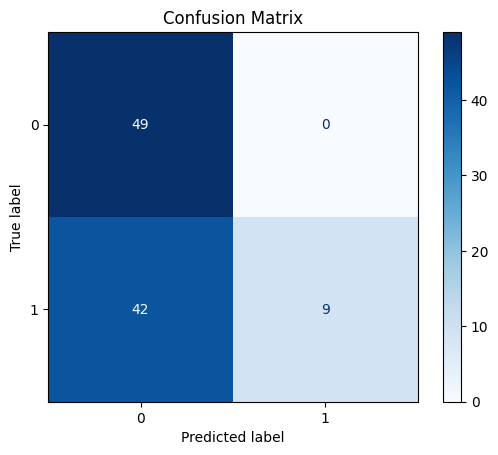

In [ ]:
# cm = confusion_matrix(df_challenge_with_preds['expected_label'], df_challenge_with_preds['predicted_label'])
# print("Confusion Matrix:\n", cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues, values_format="d")
# plt.title(f"Confusion Matrix")
# plt.show()

Best accuracy = 0.6600 at threshold = 0.005
At this threshold: Precision=1.0000, Recall=0.3333, F1=0.5000


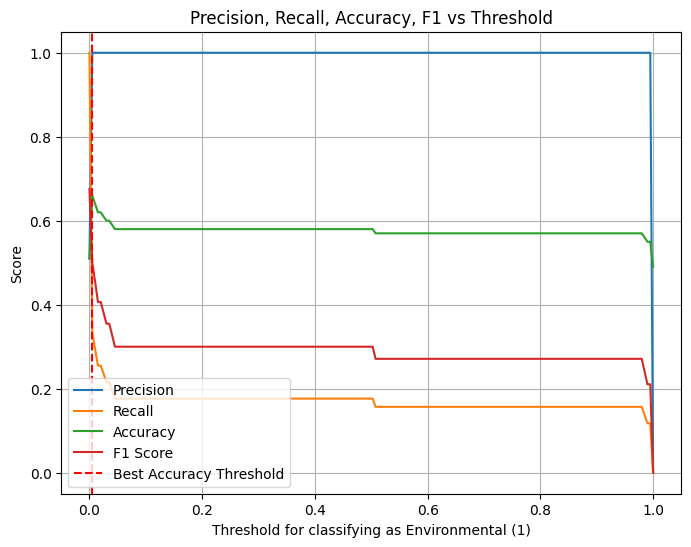

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# def evaluate_thresholds(df, model, tokenizer, thresholds=None):
#     if thresholds is None:
#         thresholds = np.linspace(0, 1, 200)

#     texts = df["text"].tolist()

#     # Forward pass once
#     inputs = tokenizer(
#         texts,
#         padding=True,
#         truncation=True,
#         max_length=256,
#         return_tensors="pt"
#     )
#     with torch.no_grad():
#         outputs = model(**{k: v.to(model.device) for k, v in inputs.items()})
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

#     # Column 1 = 'Environmental'
#     prob_E = probs[:, 1]
#     y_true = df["expected_label"].to_numpy()

#     precisions, recalls, accuracies, f1s = [], [], [], []

#     for t in thresholds:
#         preds = (prob_E >= t).astype(int)  # 1 = Environmental, 0 = not E
#         precisions.append(precision_score(y_true, preds, zero_division=0))
#         recalls.append(recall_score(y_true, preds))
#         accuracies.append(accuracy_score(y_true, preds))
#         f1s.append(f1_score(y_true, preds))

#     # Best accuracy threshold
#     best_idx = int(np.argmax(accuracies))
#     best_threshold = thresholds[best_idx]
#     best_acc = accuracies[best_idx]
#     print(f"Best accuracy = {best_acc:.4f} at threshold = {best_threshold:.3f}")
#     print(
#         f"At this threshold: Precision={precisions[best_idx]:.4f}, "
#         f"Recall={recalls[best_idx]:.4f}, F1={f1s[best_idx]:.4f}"
#     )

#     # Plot
#     plt.figure(figsize=(8, 6))
#     plt.plot(thresholds, precisions, label="Precision", marker="")
#     plt.plot(thresholds, recalls, label="Recall", marker="")
#     plt.plot(thresholds, accuracies, label="Accuracy", marker="")
#     plt.plot(thresholds, f1s, label="F1 Score", marker="")
#     plt.axvline(best_threshold, color="red", linestyle="--", label="Best Accuracy Threshold")
#     plt.xlabel("Threshold for classifying as Environmental (1)")
#     plt.ylabel("Score")
#     plt.title("Precision, Recall, Accuracy, F1 vs Threshold")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return thresholds, precisions, recalls, accuracies, f1s, best_threshold, best_acc

# thresholds, precisions, recalls, accuracies, f1s, best_threshold, best_acc = evaluate_thresholds(
#     df_challenge_100, model_E_lora, tokenizer
# )